## Data Visualization

* For classification: compare histogram every feature between the classes. Lots of examples of this in class.
* For regression: 
    * Define 2 or more class based on value of the regression target.
        * For example: if regression target is between 0 and 1:
            * 0.0-0.25: Class 1
            * 0.25-0.5: Class 2
            * 0.5-0.75: Class 3
            * 0.75-1.0: Class 4
    * Compare histograms of the features between the classes.
        
* Note that for categorical features, often times the information in the histogram could be better presented in a table.    
* Make comments on what features look most promising for ML task.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 
import scipy.stats

In [229]:
df = pd.read_csv('train.csv')

In [231]:
df.shape

(165034, 14)

In [233]:
df.tail()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.0,1,1.0,1.0,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.0,1,0.0,0.0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.0,1,1.0,1.0,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.0,1,0.0,1.0,71173.03,0
165033,165033,15732798,Ulyanov,850,France,Male,31.0,1,0.0,1,1.0,0.0,61581.79,1


In [237]:
df.duplicated().sum()

0

In [239]:
df=df.drop(columns=['id','CustomerId','Surname']) #Remove insignificant data for calculation

In [241]:
df.duplicated().sum() #reveal hidden dupes

123

In [243]:
df = df.drop_duplicates(keep='first')

In [247]:
df.duplicated().sum()

0

# Categorical Variables

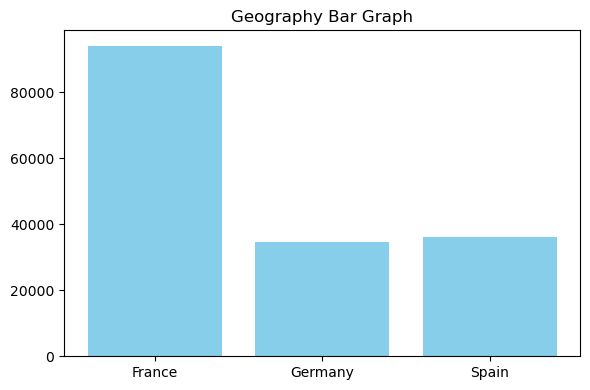

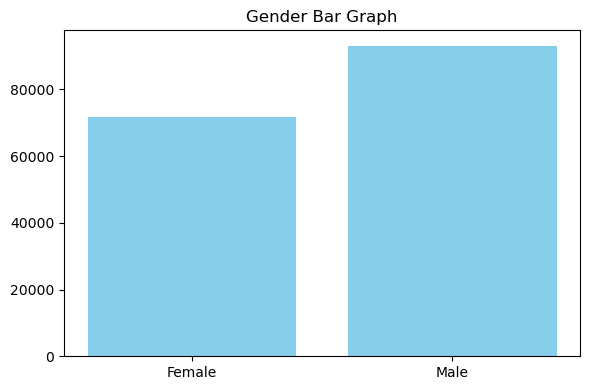

In [249]:
cat_var=['Geography','Gender']

#Bar plot for total count
for i in cat_var:
    counts = df[i].value_counts().sort_index()

    plt.figure(figsize=(6, 4))
    plt.bar(counts.index, counts.values, color='skyblue')
    plt.title(f"{i} Bar Graph")
    plt.tight_layout()
    plt.show()

In [251]:
from tabulate import tabulate
from IPython.display import HTML, display

#Table for count
for feature in cat_var:
    counts = df[feature].value_counts().sort_index()
    table = [[category, count] for category, count in counts.items()]
    html = tabulate(table, headers=[f"{feature} Category", "Count"], tablefmt='html')
    
    display(HTML(f"<h3>Value Counts for {feature}</h3>{html}"))


Geography Category,Count
France,94132
Germany,34587
Spain,36192


Gender Category,Count
Female,71836
Male,93075


In [253]:
#Table for churn rate 

for feature in cat_var:
    #use cross-tab of feature vs Exited to compare
    cross_tab = pd.crosstab(df[feature], df['Exited'])
    cross_tab.columns = ['Stayed (0)', 'Churned (1)']
    cross_tab.reset_index(inplace=True)

    html = tabulate(cross_tab.values, headers=[feature] + list(cross_tab.columns[1:]), tablefmt='html')
    display(HTML(f"<h3>Churn Breakdown by {feature}</h3>{html}"))

Geography,Stayed (0),Churned (1)
France,78562,15570
Germany,21481,13106
Spain,29959,6233


Gender,Stayed (0),Churned (1)
Female,51737,20099
Male,78265,14810


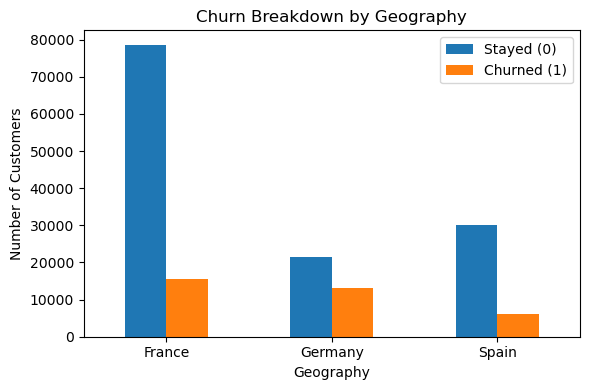

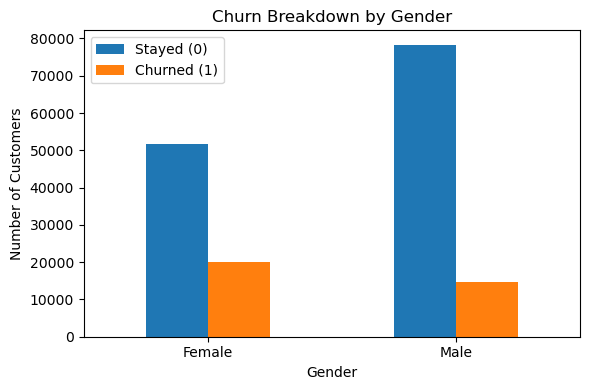

In [255]:
#Bar plot for categorical churn rate

for feature in cat_var:
    cross_tab = pd.crosstab(df[feature], df['Exited'])
    cross_tab.columns = ['Stayed (0)', 'Churned (1)']
    
    # Plot
    cross_tab.plot(kind='bar', figsize=(6,4))
    plt.title(f"Churn Breakdown by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Number of Customers")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# All variables

In [259]:
def compare_features_binary(df, target_col="Exited", logscale=False):
    df_0 = df[df[target_col] == 0] # stay, did not churn
    df_1 = df[df[target_col] == 1] # left
    
    print("Number of category 0:", df_0.shape[0])
    print("Number of category 1:", df_1.shape[0])
    
    # Drop target column for plotting features
    features = df.drop(columns=[target_col])
    N_Features = features.shape[1]
    
    N_X = math.ceil(math.sqrt(N_Features))
    N_Y = math.floor(math.sqrt(N_Features))
    if N_X * N_Y < N_Features:
        N_Y += 1

    print(f"Found {N_Features} features. Creating grid of {N_X} by {N_Y}")
    
    plt.figure(figsize=(4 * N_Y, 4 * N_X))  # moderate figure size

    for i, column in enumerate(features.columns):
        ks_stat = scipy.stats.kstest(df_0[column], df_1[column]).statistic
        ks_text = f"{column}\nKS = {ks_stat:.3f}"
        print(f"{column} - KS: {ks_stat:.3f}")

        plt.subplot(N_X, N_Y, i + 1)
        plt.title(ks_text)
        if logscale:
            plt.yscale("log")
        plt.hist(df_0[column], bins=100, histtype="step", color="red", label="Class 0", density=True)
        plt.hist(df_1[column], bins=100, histtype="step", color="blue", label="Class 1", density=True)
        plt.legend()
        plt.xlabel(column)

    plt.tight_layout()
    plt.show()

Number of category 0: 130002
Number of category 1: 34909
Found 10 features. Creating grid of 4 by 3
CreditScore - KS: 0.045
Geography - KS: 0.158
Gender - KS: 0.178
Age - KS: 0.415
Tenure - KS: 0.031
Balance - KS: 0.164
NumOfProducts - KS: 0.381
HasCrCard - KS: 0.023
IsActiveMember - KS: 0.257
EstimatedSalary - KS: 0.027


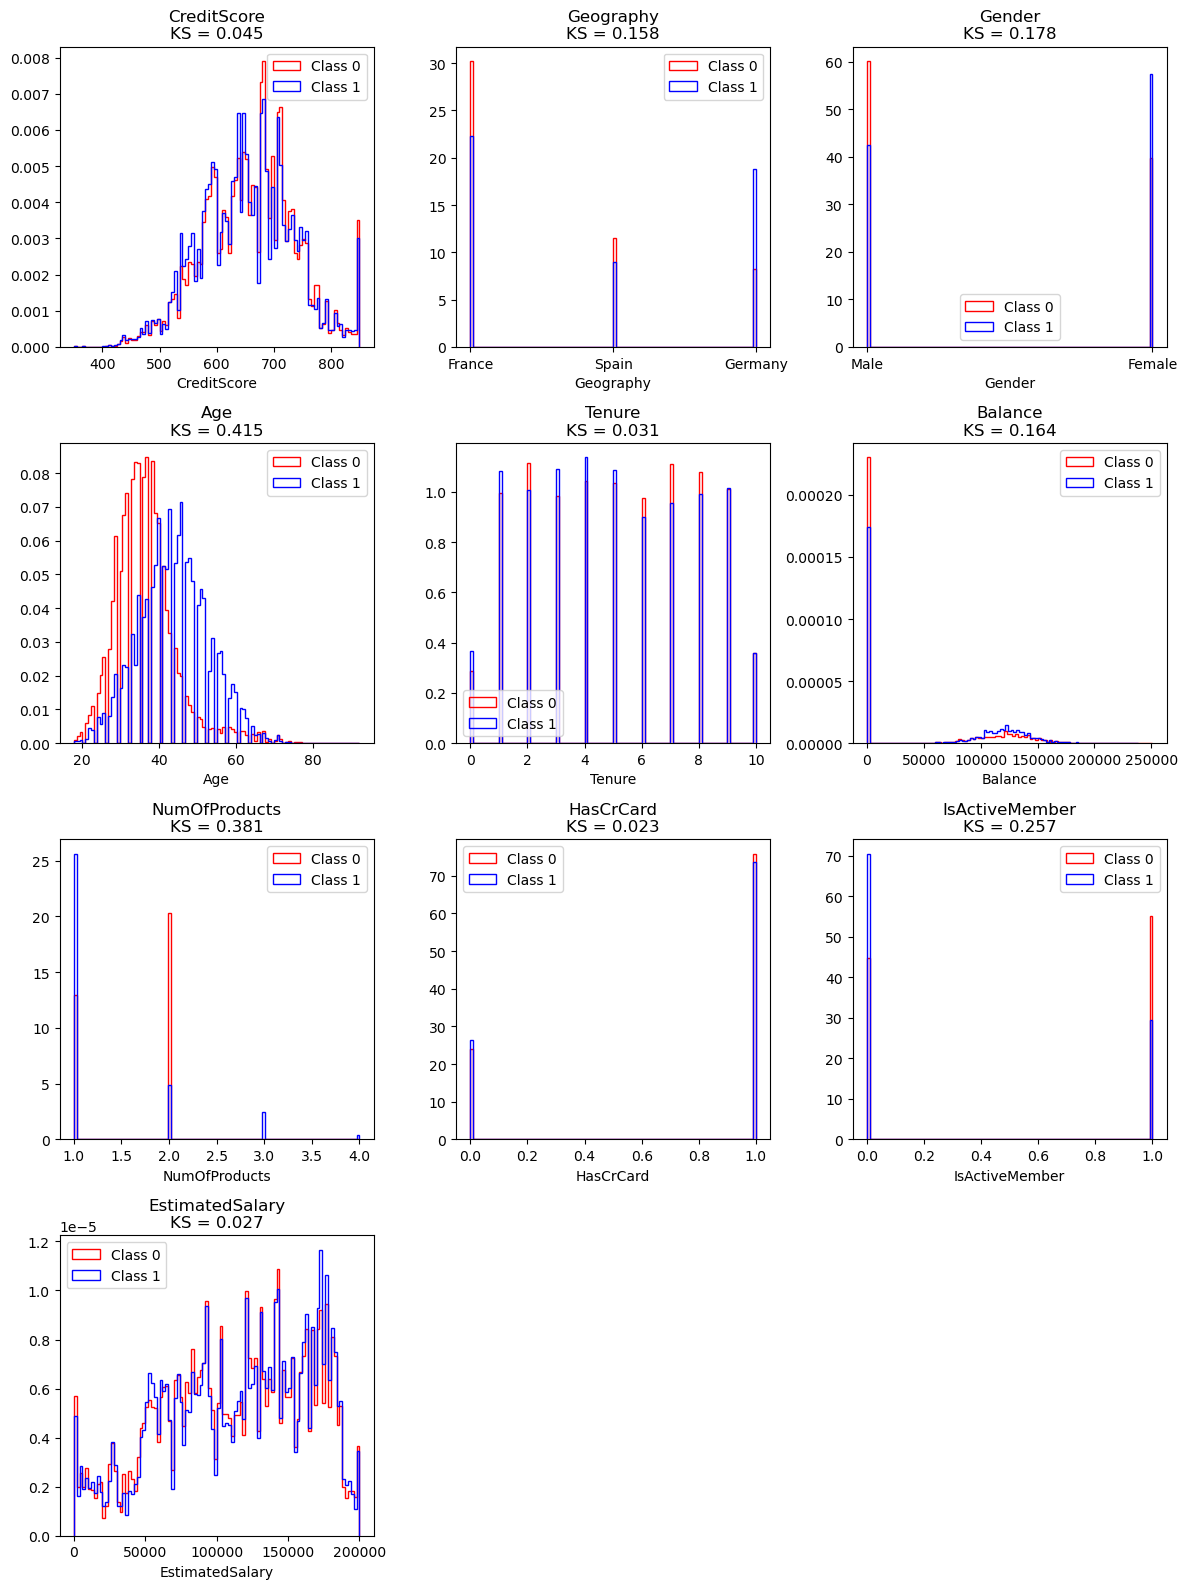

In [261]:
compare_features_binary(df)

<b> From first glance, age seem to be a good predictor. This is based on data that hasn't been normalized yet, which will be done in the next notebook. 

# Outlier Closer Look 

In [349]:
def detect_and_plot_outliers(df,columns):
    # Loop through only numeric columns
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        # Separate outliers and normal values
        normal = df[(df[col] >= lower) & (df[col] <= upper)][col]
        outliers = df[(df[col] < lower) | (df[col] > upper)][col]

        print(f"{col}: {len(outliers)} outliers")

        # Plot the histogram for normal and outlier values
        plt.figure(figsize=(6, 4))
        plt.hist(normal, bins=35, alpha=0.7, label='Normal', color='blue')
        plt.hist(outliers, bins=35, alpha=0.7, label='Outliers', color='red')
        plt.title(f"Outliers vs Normal: {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
 

CreditScore: 252 outliers


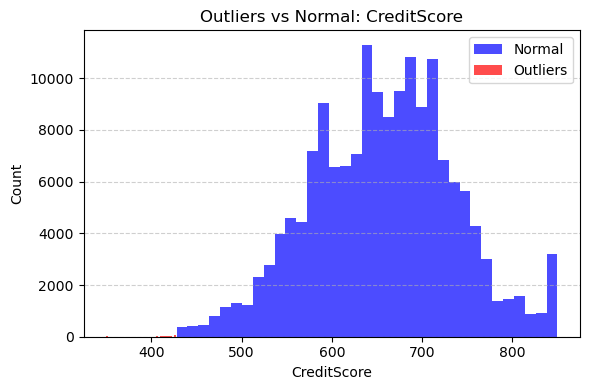

Age: 6382 outliers


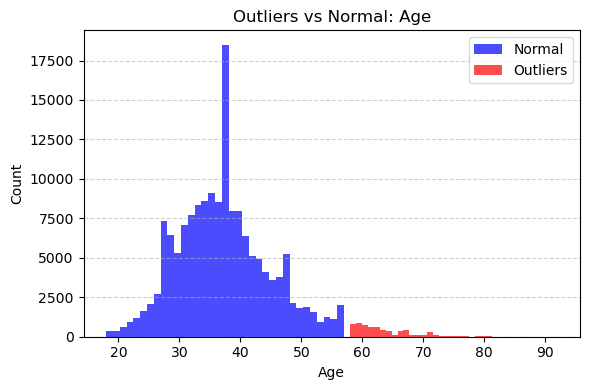

NumOfProducts: 475 outliers


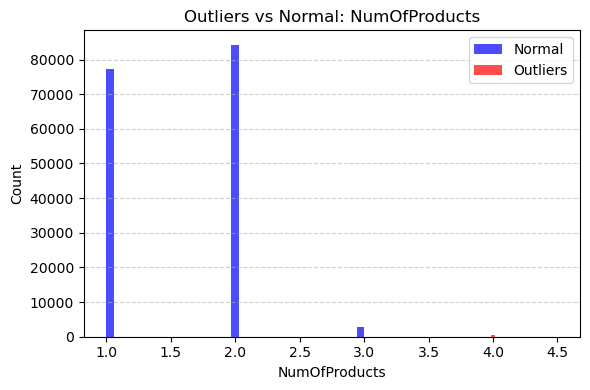

HasCrCard: 40582 outliers


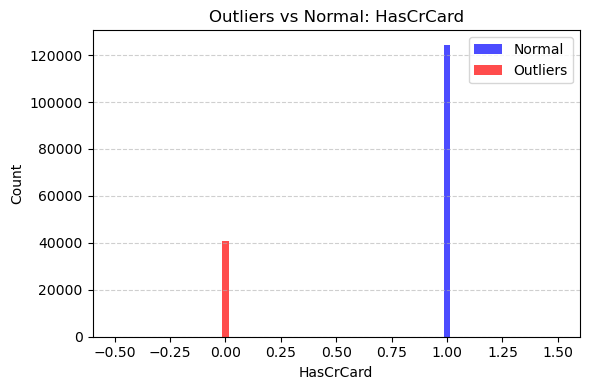

In [353]:
outlier_test_plot=['CreditScore','Age','NumOfProducts','HasCrCard']
detect_and_plot_outliers(df, outlier_test_plot)

* <b> HasCrCard outlier is not a true outlier
* <b> Credit score, age, and num of product might need to be removed